# notebook for upscaling ASO data

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np

In [2]:
import glob
from osgeo import gdal
import rasterio as rio
import rasterio.plot
from rasterio.enums import Resampling

In [3]:
swe_fns = glob.glob('data/Olympics_ASO_SWE_2016/ASO_50M*.tif',recursive=True)
swe_fns

['data/Olympics_ASO_SWE_2016/ASO_50M_SWE_USWAOL_20160208.tif',
 'data/Olympics_ASO_SWE_2016/ASO_50M_SWE_USWAOL_20160329.tif']

In [4]:
swe_fn = swe_fns[1] # change which of the two tif files to look at
imgdir = 'data/Olympics_ASO_SWE_2016/'
s='_'.join(swe_fn.split('_')[7:8])
output_fn = os.path.join(imgdir,'ASO_500m_SWE_USAWOL_'+s)
output_fn

'data/Olympics_ASO_SWE_2016/ASO_500m_SWE_USAWOL_20160329.tif'

In [5]:
!gdalinfo $swe_fn

Driver: GTiff/GeoTIFF
Files: data/Olympics_ASO_SWE_2016/ASO_50M_SWE_USWAOL_20160329.tif
Size is 1571, 1316
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1

In [6]:
src = rio.open(swe_fn)
src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1571, 'height': 1316, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(50.000101089, 0.0, 411771.0,
       0.0, -50.000101089, 5326407.0), 'tiled': False, 'interleave': 'band'}

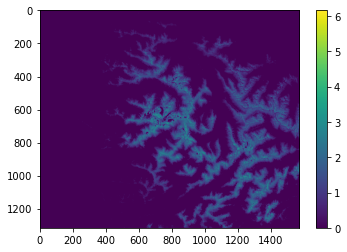

In [7]:
swe_50m = src.read(1)
f,ax = plt.subplots()
colorbar = ax.imshow(swe_50m);
f.colorbar(colorbar)

# Upscaling

In [8]:
upscale_factor = 1/10 # ooopsies isn't this technically a downscale? my bad ---eric

with rasterio.open(swe_fn) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear #billinear resamping..... change here
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [9]:
swe_500m = data[0,:,:]

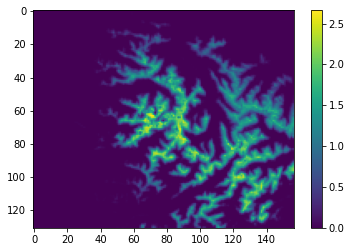

In [10]:
f,ax = plt.subplots()
colorbar = ax.imshow(swe_500m);
f.colorbar(colorbar)

# Compare

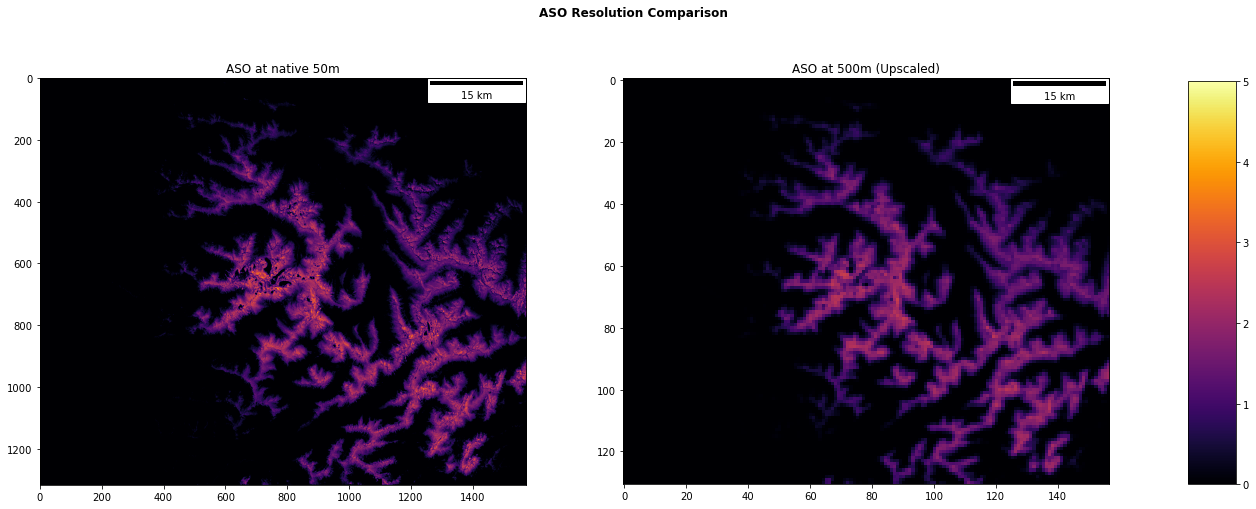

In [23]:
f, ax = plt.subplots(1,2)
cbarax = ax[0].imshow(swe_50m,cmap='inferno',vmin=0,vmax=5);
ax[0].add_artist(ScaleBar(50))
ax[0].set_title('ASO at native 50m')
ax[1].imshow(swe_500m,cmap='inferno',vmin=0,vmax=5);
ax[1].add_artist(ScaleBar(500))
ax[1].set_title('ASO at 500m (Upscaled)')

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
f.colorbar(cbarax, cax=cbar_ax)
f.set_figheight(8)
f.set_figwidth(22)
f.suptitle('ASO Resolution Comparison',fontsize='large', fontweight='bold');
plt.savefig('results/resolution_comparison.png',facecolor='w')

# Output to file

In [12]:
with rasterio.open(swe_fn) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a / upscale_factor, aff.b, aff.c,
                             aff.d, aff.e / upscale_factor, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': swe_500m.shape[0],
            'width': swe_500m.shape[1],
            'transform': newaff})  

    with rasterio.open(output_fn, 'w', **profile) as dst:
        dst.write_band(1, swe_500m)

In [13]:
!gdalinfo $output_fn

Driver: GTiff/GeoTIFF
Files: data/Olympics_ASO_SWE_2016/ASO_500m_SWE_USAWOL_20160329.tif
Size is 157, 131
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1]